# A simple example of  multilabel learning

In [1]:
%matplotlib inline

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd

from scipy.io import arff

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = 'data'
yeast_ftrain = os.path.join(data_dir, 'yeast/yeast-train.arff')
yeast_ftest  = os.path.join(data_dir, 'yeast/yeast-test.arff')

## Data loading

Load yeast dataset.

In [3]:
data_train, meta_train = arff.loadarff(yeast_ftrain)

In [4]:
data_test, meta_test = arff.loadarff(yeast_ftest)

In [5]:
type(data_train)

numpy.ndarray

In [6]:
#print(data_train[0])

In [7]:
len(list(data_train[0]))

117

Features

In [8]:
nFeatures = np.array(list(data_train[0])[:-14], dtype=np.float).shape[0]
print('#features:', nFeatures)

#features: 103


In [9]:
#np.array(list(data_train[0])[:-14], dtype=np.float)

Labels

In [10]:
nLabels = np.array(list(data_train[0])[-14:], dtype=np.int).shape[0]
print('#labels:', nLabels)

#labels: 14


In [11]:
np.array(list(data_train[0])[-14:], dtype=np.int)

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Data analysis

In [12]:
print('#training examples:', len(data_train))

#training examples: 1500


In [13]:
print('#test examples:', len(data_test))

#test examples: 917


Histogram of #positive labels.

In [14]:
nPositives = [np.sum(np.array(list(data_train[ix])[-14:], dtype=np.int)) for ix in range(len(data_train))]

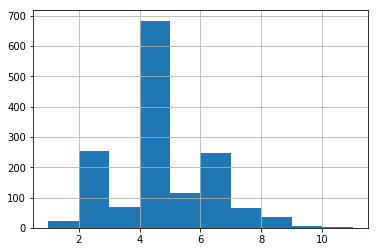

In [15]:
pd.Series(nPositives).hist(bins=10)

## Dataset creation

In [16]:
def create_dataset(label_ix, data):
    """
        Create the labelled dataset for a given label index
        
        Input:
            - label_ix: label index, number in { 0, ..., # labels }
            - data: original data with features + labels
            
        Output:
            - (Feature, Label) pair (X, y)
              X comprises the features for each example
              y comprises the labels of the corresponding example
    """

    assert(label_ix >= 0)
    assert(label_ix < nLabels)

    N = len(data)
    d = nFeatures
    
    magic = -14

    X = np.zeros((N, d), dtype = np.float)
    y = np.zeros(N, dtype = np.int)
       
    for i in range(N):
        X[i, :] = list(data[i])[:magic]
        y[i]    = list(data[i])[magic:][label_ix]

    return X, y

In [17]:
def create_dataset_v2(data):
    """
        Create the labelled dataset for a given label index
        
        Input:
            - data: original data with features + labels
            
        Output:
            - (Feature, Label) pair (X, y)
              X comprises the features for each example
              Y comprises the labels of the corresponding example
    """

    N = len(data)
    D = nFeatures
    L = nLabels

    magic = -14

    X = np.zeros((N, D), dtype = np.float)
    Y = np.zeros((N, L), dtype = np.int)
       
    for i in range(N):
        X[i, :] = list(data[i])[:magic]
        Y[i, :] = list(data[i])[magic:]

    return X, Y

## Evaluation

The sigmoid function.

In [18]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

Loss between a ground truth and a prediction.

In [19]:
def evalPred(truth, pred, lossType = 'Hamming'):
    """
        Compute loss given ground truth and prediction
        
        Input:
            - truth:    binary array of true labels
            - pred:     real-valued array of predictions
            - lossType: can be subset 0-1, Hamming, ranking, and Precision@K where K = # positive labels.
    """

    assert(len(truth) == len(pred))
    L = len(truth)
    nPos = np.sum(truth)
    
    predBin = np.array((pred > 0), dtype=np.int)
    
    if lossType == 'Subset01':
        return 1 - int(np.all(truth == predBin))
    
    elif lossType == 'Hamming':
        return np.sum(truth != predBin) / L
    
    elif lossType == 'Ranking':
        loss = 0
        for i in range(L-1):
            for j in range(i+1, L):
                if truth[i] > truth[j]:
                    if pred[i] < pred[j]: 
                        loss += 1
                    if pred[i] == pred[j]:
                        loss += 0.5
        #return loss / (nPos * (L-nPos))
        return loss
        
    elif lossType == 'Precision@K':
        # sorted indices of the labels most likely to be +'ve
        idx = np.argsort(pred)[::-1]
        
        # true labels according to the sorted order
        y = truth[idx]
        
        # fraction of +'ves in the top K predictions
        return np.mean(y[:nPos])if nPos > 0 else 0
    
    elif lossType == 'Precision@3':
        # sorted indices of the labels most likely to be +'ve
        idx = np.argsort(pred)[::-1]
        
        # true labels according to the sorted order
        y = truth[idx]
        
        # fraction of +'ves in the top K predictions
        return np.mean(y[:3])
    
    elif lossType == 'Precision@5':
        # sorted indices of the labels most likely to be +'ve
        idx = np.argsort(pred)[::-1]
        
        # true labels according to the sorted order
        y = truth[idx]
        
        # fraction of +'ves in the top K predictions
        return np.mean(y[:5])
    
    else:
        assert(False)

In [20]:
def printEvaluation(allTruths, allPreds):
    
    N = allTruths.shape[0]
    #print(N)

    for lossType in ['Precision@K']: 
        # ['Subset01', 'Hamming', 'Ranking', 'Precision@K', 'Precision@3', 'Precision@5']:
        losses = [ ]
        for i in range(allPreds.shape[0]):
            pred  = allPreds[i, :]
            truth = allTruths[i, :]
            losses.append(evalPred(truth, pred, lossType))

            #print(allPreds[i])
            #print(pred)
            #print(truth)
            #break

        #print('%24s: %1.4f' % ('Average %s Loss' % lossType, np.mean(losses)))
        print('%s: %1.4f, %.3f' % ('Average %s' % lossType, np.mean(losses), np.std(losses) / np.sqrt(N)))
        #plt.hist(aucs, bins = 10);

In [21]:
def avgPrecisionK(allTruths, allPreds):
    losses = []
    lossType = 'Precision@K'
    for i in range(allPreds.shape[0]):
        pred  = allPreds[i, :]
        truth = allTruths[i, :]
        losses.append(evalPred(truth, pred, lossType))
    return np.mean(losses)

## Binary relevance baseline

Train a logistic regression model for each label.

In [22]:
allPreds_train  = [ ]
allPreds_test  = [ ]
allTruths_train = [ ]
allTruths_test = [ ]
coefMat = [ ]
labelIndices = [ ]

parameters = [{'C': [0.01, 0.1, 1, 10, 100, 1000]}]
scoring = 'accuracy' #'precision_macro' # 'average_precision'

for label_ix in range(nLabels):
    print('Training for Label %d' % (label_ix+1))
    X_train, y_train = create_dataset(label_ix, data = data_train)
    X_test, y_test   = create_dataset(label_ix, data = data_test)
    
    allTruths_train.append(y_train)
    allTruths_test.append(y_test) 
    
    assert( (not np.all(y_train == 0)) and (not np.all(y_train == 1)) )
    
    clf = GridSearchCV(LogisticRegression(class_weight='balanced'), parameters, cv=10, scoring=scoring)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print()
    
    allPreds_train.append(clf.decision_function(X_train))
    allPreds_test.append(clf.decision_function(X_test))

Training for Label 1
Best parameters set found on development set:
{'C': 1}

Training for Label 2
Best parameters set found on development set:
{'C': 100}

Training for Label 3
Best parameters set found on development set:
{'C': 1}

Training for Label 4
Best parameters set found on development set:
{'C': 1}

Training for Label 5
Best parameters set found on development set:
{'C': 1}

Training for Label 6
Best parameters set found on development set:
{'C': 10}

Training for Label 7
Best parameters set found on development set:
{'C': 1000}

Training for Label 8
Best parameters set found on development set:
{'C': 1}

Training for Label 9
Best parameters set found on development set:
{'C': 10}

Training for Label 10
Best parameters set found on development set:
{'C': 100}

Training for Label 11
Best parameters set found on development set:
{'C': 100}

Training for Label 12
Best parameters set found on development set:
{'C': 100}

Training for Label 13
Best parameters set found on developme

In [23]:
allTruths_train = np.array(allTruths_train).T
allTruths_test = np.array(allTruths_test).T

allPreds_train  = np.array(allPreds_train).T
allPreds_test  = np.array(allPreds_test).T

print(allPreds_test.shape)
print(allTruths_test.shape)

(917, 14)
(917, 14)


In [24]:
#allPreds_test[0]

In [25]:
print('Training set:')
printEvaluation(allTruths_train, allPreds_train)
print()
print('Test set:')
printEvaluation(allTruths_test, allPreds_test)

Training set:
Average Precision@K: 0.5938, 0.008

Test set:
Average Precision@K: 0.5077, 0.010


### Result analysis

Coefficient matrix `(#Genres, #Songs)`.

In [26]:
coefMat = np.array(coefMat).T

In [27]:
coefMat.shape

(0,)

In [28]:
#sns.heatmap(coefMat[:, :30])